Copyright (C) 2020 Edouard Fouché

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program. If not, see <http://www.gnu.org/licenses/>.

In [1]:
import math

import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\usepackage{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc

from cycler import cycler

from scipy.interpolate import make_interp_spline, BSpline

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '18'
plt.rcParams['ytick.labelsize'] = '18'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999
pd.options.display.max_columns = None
cmap = cm.get_cmap('RdBu')

In [2]:
folder = "2020-02-13-07-51_Entropy_" # Replace

In [3]:
master = pd.read_csv("../experiments/" + folder + "/Entropy.csv")

In [4]:
master.columns

Index(['scoreId', 'dataset', 'bmId', 'k', 'j', 'nwords', 'ndocs', 'emb', 'cpu',
       'wall', 'cpurep', 'cpuindex', 'cpucache', 'c', 'p', 'entropythreshold',
       'miss', 'typeBrecall', 'typeBprecision', 'typeArecall',
       'typeAprecision', 'typeAauc', 'typeAap', 'typeBr1', 'typeBr2',
       'typeBr5', 'typeBr10', 'typeBr20', 'typeBr30', 'typeBp1', 'typeBp2',
       'typeBp5', 'typeBp10', 'typeBp20', 'typeBp30', 'typeBr1N', 'typeBr2N',
       'typeBr5N', 'typeBr10N', 'typeBr20N', 'typeBr30N', 'typeBp1N',
       'typeBp2N', 'typeBp5N', 'typeBp10N', 'typeBp20N', 'typeBp30N',
       'typeAr1', 'typeAr2', 'typeAr5', 'typeAr10', 'typeAr20', 'typeAr30',
       'typeAp1', 'typeAp2', 'typeAp5', 'typeAp10', 'typeAp20', 'typeAp30',
       'avgmiss', 'stdmiss', 'avgmatch', 'stdmatch', 'rep'],
      dtype='object')

In [5]:
master["ndocs"].unique()

array([10100])

In [6]:
master["dataset"].unique()

array(['nyt_1'], dtype=object)

In [7]:
master["k"].unique()

array([ 1,  2,  5, 10, 20, 30, 40, 50])

In [8]:
master["j"].unique()

array([ 0,  1,  2,  5, 10, 20, 30, 40, 50])

In [9]:
master["c"].unique()

array([ 0.01,  0.  ,  0.02,  0.1 ,  0.05,  0.2 ,  0.3 ,  0.4 ,  0.5 ])

In [10]:
master["p"].unique()

array([ 0.99,  0.98,  0.95,  0.9 ,  0.8 ,  0.7 ])

In [11]:
prettynames = {
    "typeAauc": "Type O -- AUC",
    "typeAap": "Type O -- AP",
    "typeBrecall" : "M -- Recall",
    "typeBprecision" : "M -- Precision",
    "typeArecall" : "O -- Recall",
    "typeAprecision" : "O -- Precision",
    'typeBr5' : "Type M -- Recall @ 5%",
    'typeAr5' : "Type O -- Recall @ 5%",
    'typeAr2' : "Type O -- Recall @ 2%",
    'typeAr1' : "Type O -- Recall @ 1%"
}

In [12]:
dataset = "nyt_1"
masterdata = master[(master["dataset"] == dataset)]
masterdata = masterdata.groupby(["k", "j", "c", "p"]).mean().reset_index()

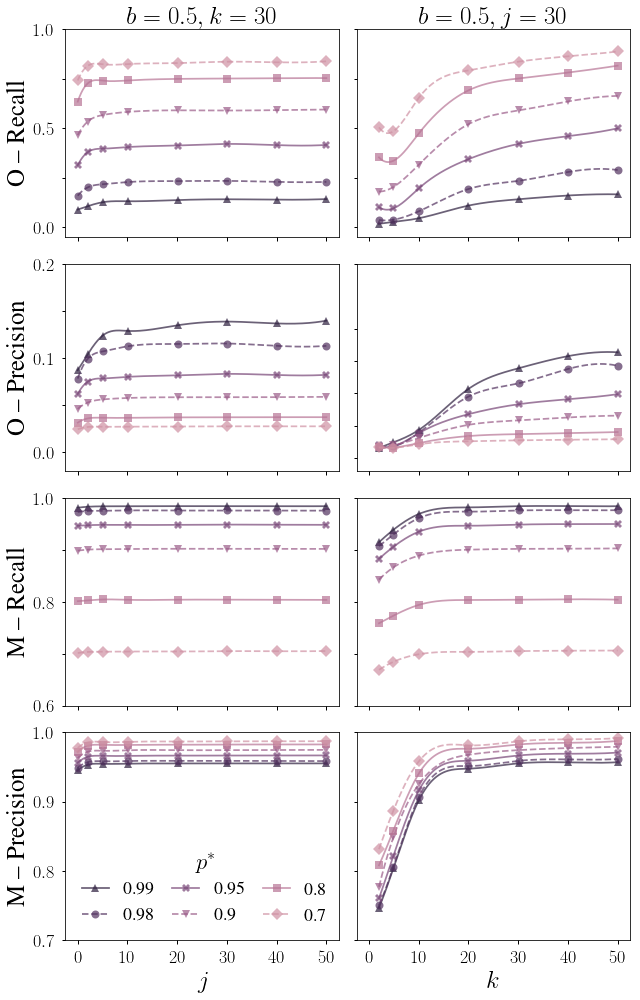

In [13]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}' 

subdata = masterdata
cmap = sns.cubehelix_palette(8, reverse=True)
markers = ["^", "o", "X", "v", "s", "D"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9,14), sharex=True, sharey="row")
axess = axes.reshape(-1)

# 'typeBrecall', 'typeBprecision', 'typeArecall', 'typeAprecision'
value = "typeArecall"

j = 30
k = 30
n = 0
c = 0.5
prange = [0.99, 0.98, 0.95,  0.9 , 0.8, 0.7] 
markersize= 8

##################

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["k"] == k)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("j")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "j"
    nspline = 300
    index = [min(int((v - toplot[x].min())/toplot[x].max() * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style,  label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.title("$b = %s, k = %s$"%(c,k))

plt.ylabel(prettynames[value])

value = "typeArecall"

n = 1

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["j"] == j)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("k")
    
    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
        
    x = "k"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style,  label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.title("$b = %s, j = %s$"%(c,k))
plt.ylim(-0.05,1)
plt.yticks([0,0.25,0.5,0.75,1.0], ["$0.0$", "", "$0.5$", "", "$1.0$"])



value = "typeAprecision"

n = 2

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["k"] == k)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("j")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
        
    x = "j"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style,  label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.ylim((-0.02,0.2))

plt.ylabel(prettynames[value])

value = "typeAprecision"

n = 3

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["j"] == j)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("k")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "k"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p, 
             marker=markers[i], markersize=markersize, markevery=index)

plt.ylim((-0.02,0.2))

plt.yticks([0,0.05,0.1,0.15,0.2,0.3], ["$0.0$", "", "$0.1$", "", "$0.2$", "$0.3$"])
plt.xticks([0,10,20,30,40,50],["$0$","$10$","$20$","$30$","$40$","$50$"])

############################

# 'typeBrecall', 'typeBprecision', 'typeArecall', 'typeAprecision'
value = "typeBrecall"

n= 4

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["k"] == k)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("j")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "j"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style,  label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.ylim((0.6,1.0))
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], ["$0.6$", "", "$0.8$", "", "$1.0$"])

plt.ylabel(prettynames[value])

value = "typeBrecall"

n = 5

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["j"] == j)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("k")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "k"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style,  label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.ylim((0.6,1.0))
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], ["$0.6$", "", "$0.8$", "", "$1.0$"])

value = "typeBprecision"

n = 6

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["k"] == k)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("j")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "j"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.ylabel(prettynames[value])
plt.xlabel("$j$")

legend = plt.legend(ncol=3, title="$p^*$", handlelength=1.5, columnspacing=1.0, fontsize=18, framealpha=0)
legend.get_title().set_fontsize('23')

plt.ylim((0.7,1.0))
plt.yticks([0.7, 0.8, 0.9, 1.0], ["", "$0.8$", "", "$1.0$"])

value = "typeBprecision"

n = 7

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["c"] == c) & (subdata["j"] == j)]
    toplot = toplot[(toplot["k"] != 1) & (toplot["j"] != 1)]
    toplot = toplot.sort_values("k")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "k"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.xlabel("$k$")

plt.ylim((0.7,1.0))
plt.yticks([0.7, 0.8, 0.9, 1.0], ["$0.7$", "$0.8$", "$0.9$", "$1.0$"])

plt.xticks([0,10,20,30,40,50],["$0$","$10$","$20$","$30$","$40$","$50$"])

################################

plt.tight_layout()
plt.savefig("plots/Figure3.pdf")

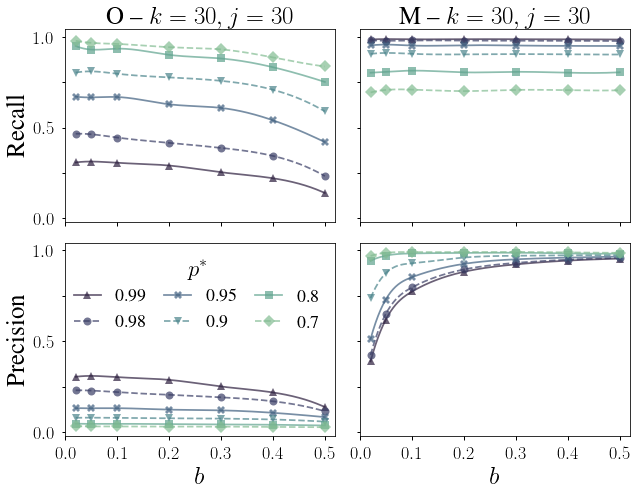

In [14]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}' 

subdata = masterdata
markers = ["^", "o", "X", "v", "s", "D"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,7), sharex=True, sharey=True)
axess = axes.reshape(-1)

# 'typeBrecall', 'typeBprecision', 'typeArecall', 'typeAprecision'
value = "typeArecall"
cmap = sns.cubehelix_palette(8, start=0.5, rot=-.75, reverse=True)

j = 30
k = 30
n = 0
prange = [0.99, 0.98, 0.95,  0.9 , 0.8, 0.7]
markersize= 8


for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["k"] == k)  & (subdata["j"] == j)]
    toplot = toplot[(toplot["c"] >= 0.02)]
    toplot = toplot.sort_values("c")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "c"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)


plt.title("O -- $k = %s, j = %s$"%(k,j))

plt.ylabel("Recall")

value = "typeBrecall"
cmap = sns.cubehelix_palette(8, start=0.5, rot=-.75, reverse=True)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0],["$0.0$", "", "$0.5$", "", "$1.0$"])


n = 1

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["k"] == k)  & (subdata["j"] == j)]
    toplot = toplot[(toplot["c"] >= 0.02)]
    toplot = toplot.sort_values("c")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "c"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)


plt.title("M -- $k = %s, j = %s$"%(k,j))
plt.yticks([0, 0.25, 0.5, 0.75, 1.0],["$0.0$", "", "$0.5$", "", "$1.0$"])



value = "typeAprecision"
cmap = sns.cubehelix_palette(8, start=0.5, rot=-.75, reverse=True)

n = 2

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["k"] == k)  & (subdata["j"] == j)]
    toplot = toplot[(toplot["c"] >= 0.02)]
    toplot = toplot.sort_values("c")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
    
    x = "c"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)


plt.ylabel("Precision")
plt.xlabel("$b$")

legend = plt.legend(ncol=3, title="$p^*$", handlelength=1.5, columnspacing=1.0, fontsize=18, framealpha=0)
legend.get_title().set_fontsize('23')
plt.yticks([0, 0.25, 0.5, 0.75, 1.0],["$0.0$", "", "$0.5$", "", "$1.0$"])

value = "typeBprecision"
cmap = sns.cubehelix_palette(8, start=0.5, rot=-.75, reverse=True)

n = 3

for i,p in enumerate(prange): # 1,2,5
    plt.sca(axess[n])
    toplot = subdata[(subdata["p"] == p) & (subdata["k"] == k)  & (subdata["j"] == j)]
    toplot = toplot[(toplot["c"] >= 0.02)]
    toplot = toplot.sort_values("c")

    if(i%2 == 0):
        style= "-"
    else:
        style= "--"
        
    x = "c"
    nspline = 300
    index = [min(int((v - toplot[x].min())/(toplot[x].max()-toplot[x].min()) * nspline),nspline-1) for v in toplot[x].unique()]
    # 300 represents number of points to do the interpolation
    xnew = np.linspace(toplot[x].min(), toplot[x].max(), nspline) 
    spl = make_interp_spline(toplot[x], toplot[value], k=3)  # type: BSpline
    toplot_smooth = spl(xnew)
    plt.plot(xnew, toplot_smooth, c= cmap[i], alpha=0.7,  linestyle=style, label=p,
             marker=markers[i], markersize=markersize, markevery=index)

plt.xlabel("$b$")
plt.xlim(0,0.52)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0],["$0.0$", "", "$0.5$", "", "$1.0$"])

plt.tight_layout()
plt.savefig("plots/Figure4.pdf")
n = 1